In [1]:
import platform; print('python:',platform.python_version()); del platform # just for version
import numpy as np; print('numpy:',np.__version__); np.set_printoptions(precision=4,suppress=True)
import matplotlib as mpl; print('matplotlib:',mpl.__version__)
import matplotlib.pyplot as plt
plt.rc('axes',grid=True,axisbelow=True,facecolor='#EAEAF2',edgecolor='w'); plt.rc('grid',color='w'); plt.rc('legend',facecolor='w',edgecolor='w',framealpha=0)
%matplotlib inline
from scipy.linalg import solve_continuous_are,solve_continuous_lyapunov
import numpy.random as rnd
from numpy.linalg import norm
from time import time; ovt0 = time()

python: 3.8.11
numpy: 1.20.3
matplotlib: 3.4.2


In [2]:
# trick to make PDF outputs of figs acceptable for IEEE submission
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [3]:
# plant
Ap = np.array([[0.,0.,1.,0.],
               [0.0487,-0.0829,0.,-1.],
               [0.,-4.546,-1.699,0.1717],
               [0.,3.382,-0.0654,-0.0893]])
Ap_eig = np.linalg.eig(Ap)[0]

Bp = np.array([[0.,0.],
               [0.,0.0116],
               [27.276,0.5758],
               [0.3952,-1.362]])

Cp = np.array([[1.,0.,0.,0.],
               [0.,1.,0.,0.]])

# dims
n = Ap.shape[0]
l = Bp.shape[1]
q = Cp.shape[0]

print('Ap:\n',Ap,Ap.shape)
print('eig:',np.linalg.eig(Ap)[0])
print('Bp:\n',Bp,Bp.shape)
print('Cp:\n',Cp,Cp.shape)

Ap:
 [[ 0.      0.      1.      0.    ]
 [ 0.0487 -0.0829  0.     -1.    ]
 [ 0.     -4.546  -1.699   0.1717]
 [ 0.      3.382  -0.0654 -0.0893]] (4, 4)
eig: [-0.0464+1.8784j -0.0464-1.8784j -1.7797+0.j      0.0014+0.j    ]
Bp:
 [[ 0.      0.    ]
 [ 0.      0.0116]
 [27.276   0.5758]
 [ 0.3952 -1.362 ]] (4, 2)
Cp:
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]] (2, 4)


In [4]:
# timesteps
dt = 0.001 # time step size
t0 = 0. # initial sim time
tf = 50. # final sim time
ts = np.arange(t0,tf+dt,dt)
print('time steps:',ts,ts.shape)

sqdt = np.sqrt(dt)

time steps: [ 0.     0.001  0.002 ... 49.998 49.999 50.   ] (50001,)


In [5]:
# Kbar is a baseline LQR controller

Qlqr = np.diag([0.,0.,0.1,5.])
R = np.eye(l)

Plqr = solve_continuous_are(Ap,Bp,Qlqr,R)

Kb = -np.linalg.solve(R,Bp.T@Plqr)
print('Kbar:\n',Kb,Kb.shape)

# matching condition for A
A = Ap + (Bp @ Kb)
print('A:\n',A,A.shape)
print('eig:',np.linalg.eig(A)[0])

Kbar:
 [[-0.1118 -0.1911 -0.2756  0.1011]
 [-0.084   0.1267 -0.0414  2.1049]] (2, 4)
A:
 [[ 0.      0.      1.      0.    ]
 [ 0.0477 -0.0814 -0.0005 -0.9756]
 [-3.0986 -9.6867 -9.2396  4.1402]
 [ 0.0702  3.1339 -0.1179 -2.9162]] (4, 4)
eig: [-8.835 +0.j     -0.3319+0.j     -1.5352+1.0673j -1.5352-1.0673j]


In [6]:
# True values for Thetabar (Kbar combined with Omegabar)

Kbar = -Kb.T

Omegabar = np.array([[4*Ap[1,1],2*Ap[1,2],2*Ap[1,3]],
                     [4*Ap[2,1],2*Ap[2,2],2*Ap[2,3]]]).T # ***NOTE***: typo in Lavretsky 2013 !!

Thetabar = np.block([[Kbar],[Omegabar]])
print('Thetabar:\n',Thetabar,Thetabar.shape)
L = Thetabar.shape[0]

def Psi(x): # Psi just returns last three of state
    return x[1:]
N = 3

def Lambda(x):
    return np.hstack([x,Psi(x)])

Thetabar:
 [[  0.1118   0.084 ]
 [  0.1911  -0.1267]
 [  0.2756   0.0414]
 [ -0.1011  -2.1049]
 [ -0.3316 -18.184 ]
 [  0.      -3.398 ]
 [ -2.       0.3434]] (7, 2)


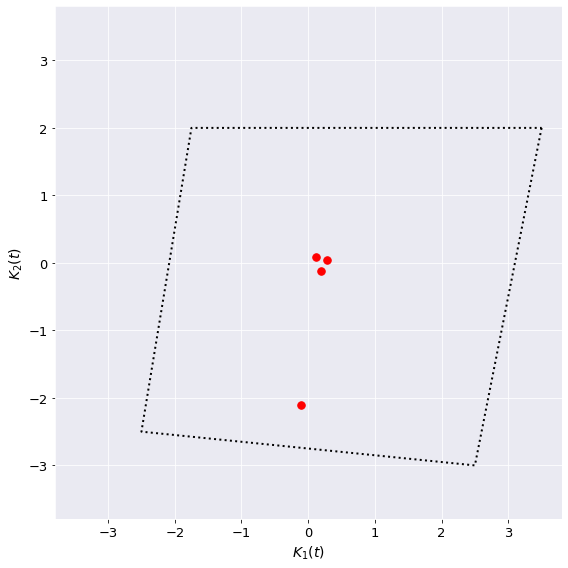

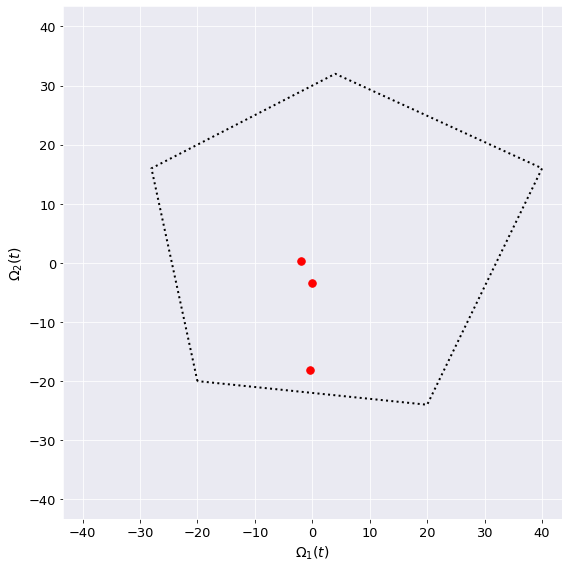

In [7]:
# Compact convex polygons (2D) used for constrains, with true values shown in red
# note: the K's below in variable names are in reference to *cal* K in the paper,
#       not the Kbar or K_t values for the stabilizing (LQR) controller

# polygon for Kbar
xK2 = 5*np.array([0.7,0.5,-0.5,-0.35])
yK2 = 5*np.array([0.4,-0.6,-0.5,0.4])
NK2 = xK2.size
cent2x,cent2y = np.mean(xK2),np.mean(yK2)

# line segment check signs with centroid as inside point
K2_cent1_signs = []
for Ni in range(NK2):
    ax,ay,bx,by = xK2[Ni],yK2[Ni],xK2[(Ni+1)%NK2],yK2[(Ni+1)%NK2]
    K2_cent1_d = (cent2x-ax)*(by-ay) - (cent2y-ay)*(bx-ax)
    K2_cent1_signs.append(np.sign(K2_cent1_d))

# polygon for Omegabar
xK1 = 40*np.array([-0.5,-0.7,0.1,1.,0.5])
yK1 = 40*np.array([-0.5,0.4,0.8,0.4,-0.6])
NK1 = xK1.size
cent1x,cent1y = np.mean(xK1),np.mean(yK1)

# line segment check signs with centroid as inside point
K1_cent1_signs = []
for Ni in range(NK1):
    ax,ay,bx,by = xK1[Ni],yK1[Ni],xK1[(Ni+1)%NK1],yK1[(Ni+1)%NK1]
    K1_cent1_d = (cent1x-ax)*(by-ay) - (cent1y-ay)*(bx-ax)
    K1_cent1_signs.append(np.sign(K1_cent1_d))


# actual projection function, analytic method in this case
def proj2DCCpoly(p,xK,yK,K_cent_signs):  # (px,py) is the point to be projected (if necessary)
    minProjLen = np.inf
    NK = xK.size
    px,py = p.copy()

    # line segment checks
    for Ni in range(NK):
        ax,ay,bx,by = xK[Ni],yK[Ni],xK[(Ni+1)%NK],yK[(Ni+1)%NK]
        K_p_d = (px-ax)*(by-ay) - (py-ay)*(bx-ax)
        if K_p_d == 0. or np.sign(K_p_d)==K_cent_signs[Ni]: pass
        else:
            # projection for line segment with failed check
            t = ((px-ax)*(bx-ax)+(py-ay)*(by-ay))/((bx-ax)**2 + (by-ay)**2)
            if t > 1: t = 1
            elif t < 0: t = 0

            projx = ax + t*(bx-ax)
            projy = ay + t*(by-ay)

            projLen = norm(np.array([projx-px,projy-py]))
            if projLen <= minProjLen:
                minProjLen = projLen
                ProjX,ProjY = projx,projy

    if minProjLen < np.inf: return np.array([ProjX,ProjY])
    else: return p


# plot bounds with actual (bar) values
plt.figure(figsize=(8,8))
for r in range(n):
    plt.plot(Kbar[r,0],Kbar[r,1],'r.',ms=15)
plt.plot(np.hstack([xK2,xK2[0]]),np.hstack([yK2,yK2[0]]),'k:',lw=2.,label='K bounds')
plt.xlabel(r'$K_{1}(t)$',fontsize=14)
plt.ylabel(r'$K_{2}(t)$',fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
y1,y2 = plt.ylim()
x1,x2 = plt.xlim()
maxxy = max(np.abs([y1,y2,x1,x2]))
plt.ylim(-maxxy,maxxy)
plt.xlim(-maxxy,maxxy)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,8))
for r in range(N):
    plt.plot(Omegabar[r,0],Omegabar[r,1],'r.',ms=15)
plt.plot(np.hstack([xK1,xK1[0]]),np.hstack([yK1,yK1[0]]),'k:',lw=2.,label='K bounds')
plt.xlabel(r'$\Omega_{1}(t)$',fontsize=14)
plt.ylabel(r'$\Omega_{2}(t)$',fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
y1,y2 = plt.ylim()
x1,x2 = plt.xlim()
maxxy = max(np.abs([y1,y2,x1,x2]))
plt.ylim(-maxxy,maxxy)
plt.xlim(-maxxy,maxxy)
plt.tight_layout()
plt.show()

In [8]:
# Adaptive controller setup

Q = np.diag([0.,0.,10.,800.])
P = solve_continuous_lyapunov(A.T,-Q) # note: Aref.T has to be used in this function
print('P:\n',P,P.shape)
print('P eig:',np.linalg.eig(P)[0])

P:
 [[  4.4853  25.6833   0.3225  -3.228 ]
 [ 25.6833 393.548    1.4467  14.6974]
 [  0.3225   1.4467   0.5944  -1.4422]
 [ -3.228   14.6974  -1.4422 130.2009]] (4, 4)
P eig: [396.027  129.5708   2.6743   0.5565]


Coupled! Tau: 35.779
seedN: 123
simulation time: 12.9 sec


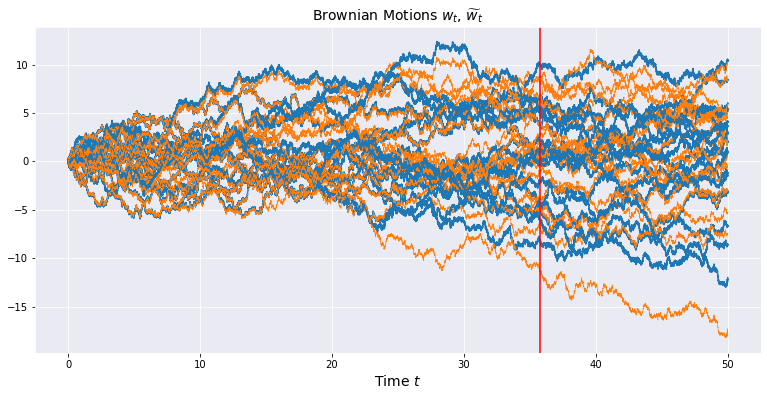

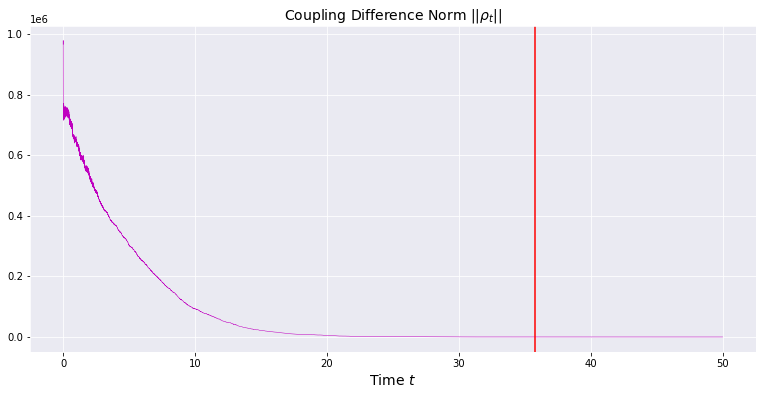

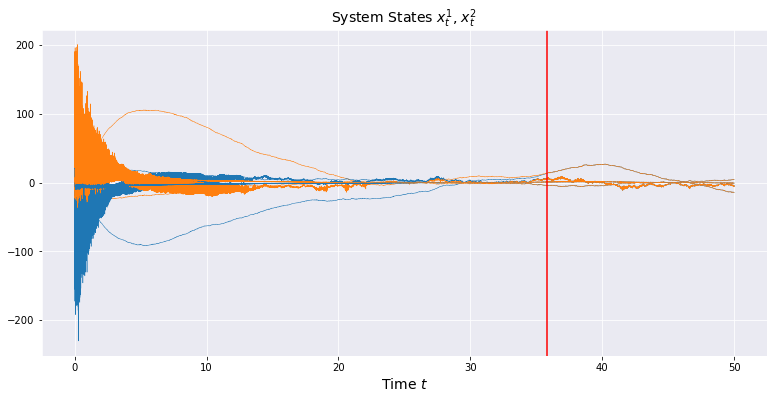

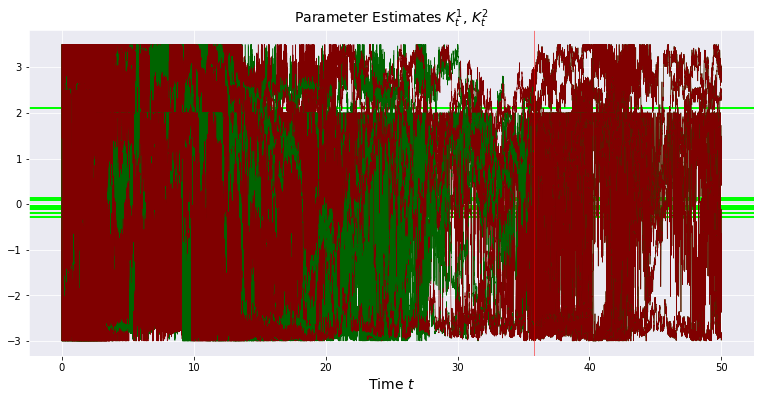

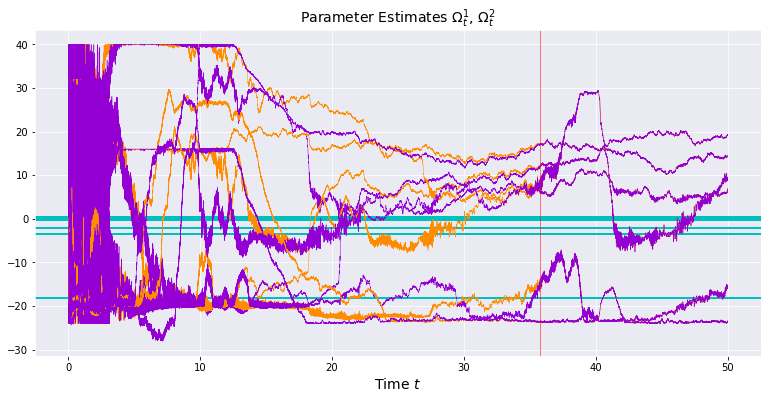

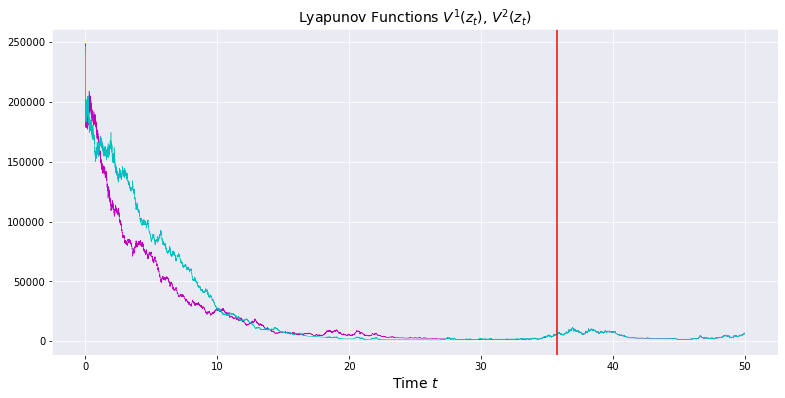

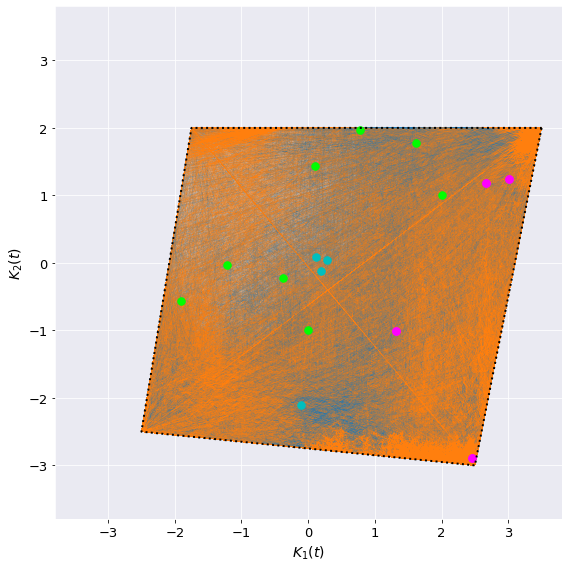

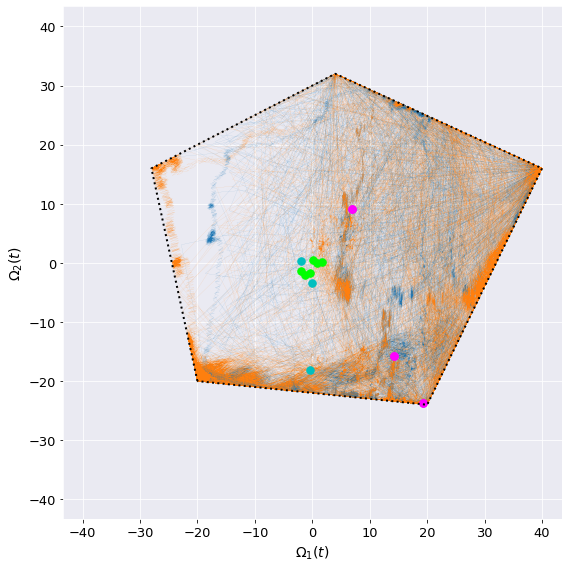

In [9]:
# Simulation according to paper theory

m = L*l # total number of parameters
omN = n + n*l # index for reaching Omega params within zi

def M(vec): return np.reshape(vec,(L,l)) # m --> L,l
def Minv(Mat): return np.ravel(Mat)  # L,l --> m such that [[1,2],[3,4]] --> [1,2,3,4]

# H function
def H(z):
    x = z[:n]
    th = z[n:]
    Hx = Ap @ x + Bp @ (Thetabar - M(th)).T @ Lambda(x)
    Hth = Minv(np.outer(Lambda(x),x) @ P @ Bp)
    return np.hstack([Hx,Hth])

# P for ||rho||_P
Prho = np.block([[P,np.zeros((n,m))],[np.zeros((m,n)),np.eye(m)]])

# make G matrix (Brownian motion coefficients - must be invertible) and Ginv
gx = 1.
gK = 1.
gom = 1.
Gx = gx*np.eye(n)
GK = gK*np.eye(n*l)
Gom = gom*np.eye(N*l)
# G is block diagonal of G_x and G_theta, with latter as block diag. of G_K and G_omega
G = np.block([[Gx,np.zeros((n,m))], # cols = n + m = 4 + 14 = 18
              [np.zeros((n*l,n)),GK,np.zeros((n*l,N*l))], # cols = n + n*l + N*l = 4 + 8 + 6 = 18
              [np.zeros((N*l,omN)),Gom]]) # cols = n + n*l + N*l = 18
Ginv = np.linalg.inv(G)

# combined state init
xn = 20.
x0 = xn*np.array([1.,1.,1.,1.])

thn1 = 1.
thn2 = 1.
thx = np.linspace(0.,(L-1/L)*2*np.pi,L)
Th0 = np.zeros((L,2))
Th0[:,0] = np.cos(thx) + thn1
Th0[:,1] = np.sin(thx) + thn1

Th02 = np.zeros((L,2))
Th02[:,0] = np.cos(thx) - thn2
Th02[:,1] = np.sin(thx) - thn2

z1 = np.zeros((n+m,ts.size))
z1[:n,0] = x0
z1[n:,0] = Minv(Th0)
z2 = np.zeros((n+m,ts.size))
z2[:n,0] = -x0
z2[n:,0] = Minv(Th02)

# brownian motions init
w = np.zeros((n+m,ts.size))
wt = np.zeros((n+m,ts.size))

# coupling init
rhoNorm = np.zeros(ts.size)
coupled = False
tau = None

# Lyapunovs init
V1 = np.zeros(ts.size)
V2 = np.zeros(ts.size)

# projection on/off
proj = True

# Euler integration simulation
seedN = 123
rnd.seed(seedN)

tr0 = time()
for ti,t in enumerate(ts[:-1]):

    # coupling difference norm
    rho = z1[:,ti] - z2[:,ti]
    rhoNorm[ti] = rho @ Prho @ rho
    if not coupled and rhoNorm[ti] < 0.05:
        coupled = True
        tau = t
        print('Coupled! Tau:',tau)
        print('seedN:',seedN)
        z1[:,ti] = z2[:,ti]

    # Lyapunovs
    x1 = z1[:n,ti]
    th1 = z1[n:,ti]
    V1[ti] = x1 @ P @ x1 + th1 @ th1 + 1
    x2 = z2[:n,ti]
    th2 = z2[n:,ti]
    V2[ti] = x2 @ P @ x2 + th2 @ th2 + 1

    # dw_t ~ N(0,sqrt(dt))
    dw = sqdt*rnd.randn(n+m)
    w[:,ti+1] = w[:,ti] + dw

    # dwtilde_t = (I - 2uu^T)dw_t
    if not coupled:
        Ginvrho = Ginv @ rho
        u = Ginvrho/norm(Ginvrho)
        dwt = (np.eye(n+m) - 2*np.outer(u,u)) @ dw
    else:
        dwt = dw
    wt[:,ti+1] = wt[:,ti] + dwt

    # unprojected Euler update
    z1[:,ti+1] = z1[:,ti] + H(z1[:,ti])*dt + G@dw
    z2[:,ti+1] = z2[:,ti] + H(z2[:,ti])*dt + G@dwt

    # projection for the psi estimates, if needed
    if proj:
        # for K
        for ind in range(n,omN,2):
            z1[ind:(ind+2),ti+1] = proj2DCCpoly(z1[ind:(ind+2),ti+1],xK2,yK2,K2_cent1_signs)
            z2[ind:(ind+2),ti+1] = proj2DCCpoly(z2[ind:(ind+2),ti+1],xK2,yK2,K2_cent1_signs)
        
        # for Omega
        for ind in range(omN,n+m,2):
            z1[ind:(ind+2),ti+1] = proj2DCCpoly(z1[ind:(ind+2),ti+1],xK1,yK1,K1_cent1_signs)
            z2[ind:(ind+2),ti+1] = proj2DCCpoly(z2[ind:(ind+2),ti+1],xK1,yK1,K1_cent1_signs)

# hold over last values for coupling difference norms and Lyapunovs
rhoNorm[ti+1] = rhoNorm[ti]
V1[ti+1] = V1[ti]
V2[ti+1] = V2[ti]

# end simulation and report run time
print('simulation time: %.1f sec'%(time()-tr0))

# plots

# Brownian motions - synchronous after coupling
plt.figure(figsize=(13,6))
for i in range(n+m):
    plt.plot(ts,w[i],'C0',lw=1.5)
    plt.plot(ts,wt[i],'C1',lw=0.5)
if tau is not None: plt.axvline(tau,c='r')
plt.title(r'Brownian Motions $w_t$, $\widetilde{w}_t$',fontsize=14)
plt.xlabel(r'Time $t$',fontsize=14)
plt.show()

# ||rho||
plt.figure(figsize=(13,6))
# plt.axhline(0.05,c='c',lw=1.)
plt.plot(ts,rhoNorm,'m',lw=0.5)
if tau is not None: plt.axvline(tau,c='r')
# plt.ylim([0,1])
plt.title(r'Coupling Difference Norm $||\rho_t||$',fontsize=14)
plt.xlabel(r'Time $t$',fontsize=14)
plt.show()

# system states x1, x2
plt.figure(figsize=(13,6))
for i in range(n):
    plt.plot(ts,z1[i],'C0',lw=0.5)
    plt.plot(ts,z2[i],'C1',lw=0.5)
if tau is not None: plt.axvline(tau,c='r')
plt.title(r'System States $x_t^1$, $x_t^2$',fontsize=14)
plt.xlabel(r'Time $t$',fontsize=14)
plt.show()

# parameter estimates K1, K2
kb = Minv(Kb)
plt.figure(figsize=(13,6))
for i in range(n*l):
    plt.axhline(kb[i],c='lime',lw=2.)
for i in range(n*l): # don't combine, because these should be "on top of" the true lines
    plt.plot(ts,z1[n+i],'darkgreen',lw=0.5)
    plt.plot(ts,z2[n+i],'maroon',lw=0.5)
if tau is not None: plt.axvline(tau,c='r',lw=0.5)
plt.title(r'Parameter Estimates $K_t^1$, $K_t^2$',fontsize=14)
plt.xlabel(r'Time $t$',fontsize=14)
plt.show()

# parameter estimates omega1, omega2
omegab = Minv(Omegabar)
plt.figure(figsize=(13,6))
for i in range(N*l):
    plt.axhline(omegab[i],c='c',lw=2.)
for i in range(N*l): # don't combine, because these should be "on top of" the true lines
    plt.plot(ts,z1[omN+i],'darkorange',lw=0.5)
    plt.plot(ts,z2[omN+i],'darkviolet',lw=0.5)
if tau is not None: plt.axvline(tau,c='r',lw=0.5)
plt.title(r'Parameter Estimates $\Omega_t^1$, $\Omega_t^2$',fontsize=14)
plt.xlabel(r'Time $t$',fontsize=14)
plt.show()

# Lyapunovs
plt.figure(figsize=(13,6))
plt.plot(ts,V1,'m',lw=0.5)
plt.plot(ts,V2,'c',lw=0.5)
if tau is not None: plt.axvline(tau,c='r')
plt.title(r'Lyapunov Functions $V^1(z_t)$, $V^2(z_t)$',fontsize=14)
plt.xlabel(r'Time $t$',fontsize=14)
plt.show()

# 2D phase plots for the trajectory over time of each row in K

def M_n(vec): return np.reshape(vec,(n,l))
K1 = np.zeros((*Kb.T.shape,ts.size))
K2 = np.zeros((*Kb.T.shape,ts.size))
for ti in range(ts.size):
    K1[...,ti] = M_n(z1[n:omN,ti])
    K2[...,ti] = M_n(z2[n:omN,ti])

plt.figure(figsize=(8,8))
for r in range(n):
    plt.plot(K1[r,0],K1[r,1],'C0',lw=0.05)
    plt.plot(K2[r,0],K2[r,1],'C1',lw=0.05)
for r in range(n):
    plt.plot(K1[r,0,0],K1[r,1,0],c='lime',marker='.',ms=15)
    plt.plot(K1[r,0,-1],K1[r,1,-1],c='fuchsia',marker='.',ms=15)
    plt.plot(K2[r,0,0],K2[r,1,0],c='lime',marker='.',ms=15)
    plt.plot(K2[r,0,-1],K2[r,1,-1],c='fuchsia',marker='.',ms=15)
    plt.plot(Kbar[r,0],Kbar[r,1],'c.',ms=15)
plt.plot(np.hstack([xK2,xK2[0]]),np.hstack([yK2,yK2[0]]),'k:',lw=2.,label='K bounds')
plt.xlabel(r'$K_{1}(t)$',fontsize=14)
plt.ylabel(r'$K_{2}(t)$',fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
y1,y2 = plt.ylim()
x1,x2 = plt.xlim()
maxxy = max(np.abs([y1,y2,x1,x2]))
plt.ylim(-maxxy,maxxy)
plt.xlim(-maxxy,maxxy)
plt.tight_layout()
plt.show()

# 2D phase plots for the trajectory over time of each row in Omega

def M_N(vec): return np.reshape(vec,(N,l))
Omega1 = np.zeros((*Omegabar.shape,ts.size))
Omega2 = np.zeros((*Omegabar.shape,ts.size))
for ti in range(ts.size):
    Omega1[...,ti] = M_N(z1[omN:,ti])
    Omega2[...,ti] = M_N(z2[omN:,ti])

plt.figure(figsize=(8,8))
for r in range(N):
    plt.plot(Omega1[r,0],Omega1[r,1],'C0',lw=0.05)
    plt.plot(Omega2[r,0],Omega2[r,1],'C1',lw=0.05)
for r in range(N):
    plt.plot(Omega1[r,0,0],Omega1[r,1,0],c='lime',marker='.',ms=15)
    plt.plot(Omega1[r,0,-1],Omega1[r,1,-1],c='fuchsia',marker='.',ms=15)
    plt.plot(Omega2[r,0,0],Omega2[r,1,0],c='lime',marker='.',ms=15)
    plt.plot(Omega2[r,0,-1],Omega2[r,1,-1],c='fuchsia',marker='.',ms=15)
    plt.plot(Omegabar[r,0],Omegabar[r,1],'c.',ms=15)
plt.plot(np.hstack([xK1,xK1[0]]),np.hstack([yK1,yK1[0]]),'k:',lw=2.,label='K bounds')
plt.xlabel(r'$\Omega_{1}(t)$',fontsize=14)
plt.ylabel(r'$\Omega_{2}(t)$',fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
y1,y2 = plt.ylim()
x1,x2 = plt.xlim()
maxxy = max(np.abs([y1,y2,x1,x2]))
plt.ylim(-maxxy,maxxy)
plt.xlim(-maxxy,maxxy)
plt.tight_layout()
plt.show()